In [1]:
#Eureka AirSnow
#compares the altitudes of the atm laser data within a footprint to the 70% threshold of the footprint's waveform's air-snow peak
# (for all waveforms that contain an identifiable air-snow interface peak)
# also creates ATM-ku offsets for each flyover above the Eureka fyi and myi sites
# Claude de Rijke-Thomas
#last modified: 8th May 2022 

In [4]:
icetype = 'fyi' #the ice type that we want to be investigating (can either be fyi or myi)
from LPS_functions import *

In [5]:
#initialising empty arrays:
lat = np.array([], dtype='double')
lon = np.array([], dtype='double')
b_as = np.array([],dtype='int')
b_si = np.array([], dtype='int')
snow_depth_dot_n = np.array([], dtype='double')

insitu_data_filepath = '/Users/claudederijkethomas/Desktop/PhD/PYTHON/OIB/'\
                        +'19-21Apr2016/SR/insitu_data_eureka.csv'

#opening the csv file to read through (to make a loading bar of progress):
line_count=0
with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    for line in readCSV:
        line_count+=1        
#Timestamp,Counter,DepthCm,Latitude,Longitude,Site,IceType are the headers
Timestamp = np.array([], dtype='str')
Counter = np.array([], dtype='int')
DepthCm = np.array([], dtype='double')
Latitude = np.array([], dtype='double')
Longitude = np.array([], dtype='double')
Site = np.array([], dtype='str')
IceType = np.array([], dtype='str')

with open(insitu_data_filepath, 'r') as csvfile:
    readCSV = csv.DictReader(csvfile)
    #establishing the headers as the first line of the file:
    headers = readCSV.fieldnames
    count=-1
    for line in readCSV:
        count+=1
        if count%1000==0:
            sys.stdout.write("\r"+str(100*count/line_count)+"% of the way ")
        if str(line['Timestamp'][0:2]).isdigit():
            if int(line['Timestamp'][0:2])>=15: # if data is taken on the 15th or later
                if str(line['IceType'])==icetype:
                    Timestamp = np.append(Timestamp, str(line['Timestamp']))
                    Counter = np.append(Counter, int(line['Counter']))
                    DepthCm = np.append(DepthCm, float(line['DepthCm']))
                    Latitude = np.append(Latitude, float(line['Latitude']))
                    Longitude = np.append(Longitude, float(line['Longitude']))
                    Site = np.append(Site, str(line['Site']))
                    IceType = np.append(IceType, str(line['IceType']))

    sys.stdout.write("\r"+"100% complete                 ")

100% complete                  

In [6]:
insitu_xs, insitu_ys = easeProj(Longitude,Latitude)
insitu_kdtree = spatial.cKDTree(np.column_stack((insitu_xs, insitu_ys)))


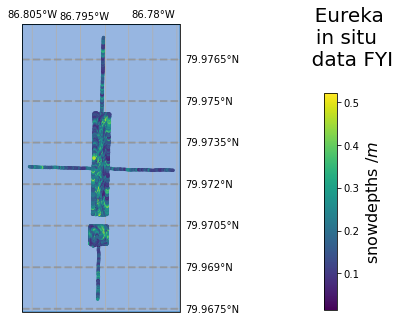

In [7]:
fig = plt.figure()

central_lon,central_lat = np.mean(Longitude),np.mean(Latitude)
ax = fig.add_axes([0,0,0.77,1], projection=ccrs.Orthographic(central_lon,central_lat))
scat = ax.scatter(Longitude,Latitude,s=5,c=DepthCm,transform=ccrs.PlateCarree(), zorder=3)
ax.gridlines()
cbar_ax = fig.add_axes([0.90, 0.007, 0.03, 0.753]) #start xpos, start ypos, #xwidth, ylendth
cbar_ax.set_title("       Eureka \n     in situ\n       data "+str(icetype).upper()+"\n",fontsize=20)
lol = cbar_ax.scatter(x=np.zeros(len(DepthCm)),y=np.zeros(len(DepthCm)),c=DepthCm/100)
cb = fig.colorbar(lol, cax=cbar_ax)
cb.set_label('snowdepths $/m$', size=16)

ax.coastlines(resolution='50m')
ocean110 = cartopy.feature.NaturalEarthFeature('physical', 'ocean', \
    scale='50m', edgecolor='none', facecolor=cartopy.feature.COLORS['water'])
ax.add_feature(ocean110)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels = False
gl.top_labels = True
gl.left_labels = False
gl.xlines = False

xlims = ax.get_xlim()
ylims = ax.get_ylim()

extent_lonlat = ax.get_extent(crs=ccrs.PlateCarree())

dataExtentPolygon = Polygon([(extent_lonlat[0],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[2]),\
                             (extent_lonlat[1],extent_lonlat[3]),\
                             (extent_lonlat[0],extent_lonlat[3])])
ax.plot(*dataExtentPolygon.exterior.xy,transform=ccrs.PlateCarree())

ax.set_extent(extent_lonlat,crs=ccrs.PlateCarree())
plt.show()

In [8]:
if icetype=='fyi':
    coincident_ku_files = ['IRKUB1B_20160419_04_004_deconv.nc', 'IRKUB1B_20160419_04_032_deconv.nc', 'IRKUB1B_20160419_04_050_deconv.nc', 'IRKUB1B_20160419_04_080_deconv.nc', 'IRKUB1B_20160419_04_180_deconv.nc', 'IRKUB1B_20160419_04_208_deconv.nc', 'IRKUB1B_20160419_04_230_deconv.nc', 'IRKUB1B_20160419_04_258_deconv.nc', 'IRKUB1B_20160419_04_259_deconv.nc']
elif icetype=='myi':
    coincident_ku_files = ['IRKUB1B_20160419_04_035_deconv.nc', 'IRKUB1B_20160419_04_047_deconv.nc', 'IRKUB1B_20160419_04_083_deconv.nc', 'IRKUB1B_20160419_04_176_deconv.nc', 'IRKUB1B_20160419_04_211_deconv.nc', 'IRKUB1B_20160419_04_226_deconv.nc', 'IRKUB1B_20160419_04_262_deconv.nc']

In [9]:
"""Making an overlapping KDTree of all the atm data from all of the flyovers"""
all_overlapping_h5_files = []
for ku_file in coincident_ku_files:
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                all_overlapping_h5_files.append(coinc[0])
                ku_files = coinc[1]
                
all_overlapping_h5_files = list(dict.fromkeys(all_overlapping_h5_files))
atm_laser = projectedLaser(all_overlapping_h5_files, "ease")
x_atm_laser,y_atm_laser = atm_laser.east, atm_laser.north

overlapping_kdtree = spatial.cKDTree(np.column_stack((x_atm_laser, y_atm_laser)))

In [10]:
"""using the ATM laser file offsets to align each ATM laser file to each other (each ATM file has an altimetric offset relative to the others
 determined by its mean patch offset, relative to the overall mean patch elevation of the ATM laser files combined).
 These offsets are calculated in Eureka_ATM_laser_Offsets.ipynb"""
if icetype == 'fyi':
    #this is  mean_atm_elev_each_flyover - np.mean(mean_atm_elev_each_flyover)
    atm_elev_flyover_offsets = [-0.00142218, -0.00882589, -0.0182781, -0.01468046, -0.06314833, 0.0375774, 0.02246962, 0.02315396, 0.02315396] #for first year ice!!!!
elif icetype == 'myi':
    atm_elev_flyover_offsets = [-0.01541401, -0.02724434, -0.00367711, -0.05813091, 0.03078281, 0.03742214, 0.03626142]
all_overlapping_atm_alts_arr = np.array([],dtype='double')
for i,ku_file in enumerate(coincident_ku_files):
    h5_files = []
    for coinc in coincidence_arr:
        for sub_arr in coinc:
            if ku_file in sub_arr:
                #finding the kdtree that corresponds to the atm laser data file that coincides with ku_file:
                h5_files.append(coinc[0])
                ku_files = coinc[1]
    atm = projectedLaser(h5_files, "ease")
    all_overlapping_atm_alts_arr = np.append(all_overlapping_atm_alts_arr, atm.alt - atm_elev_flyover_offsets[i])
    
#overriding the atm altitudes to compensate for the offsets between the atm files:
atm_laser.alt = all_overlapping_atm_alts_arr

In [20]:
offset_list_2D = []
angle_thresh=3

for ku_file_counter, ku_file in enumerate(coincident_ku_files):
    offset_list_file = []
    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    j=-1
    for footprint, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            unlog_amp = 10**(np.array(log_amplitude[j])/10)
            try:
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
            except:
                print(Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                offset_list_file.append(np.nanmean(atm_alts_within) - Waveform(unlog_amp,fasttime_ku,footprint_atm_alts = atm_alts_within,aircraft_alt=aircraft_alt_ku[j]).estimated_air_snow_alt)
                raise

    offset_list_2D.append(offset_list_file)

[ 0.09616248  0.07145191  0.05828274  0.01450113 -0.04183004 -0.02992244
 -0.00074517 -0.03512533 -0.03456479]
[0.05746733 0.06804965 0.06556756 0.06409278 0.05090897 0.05719533
 0.05332833 0.05229018 0.06637376]
[483. 381. 451. 453. 477. 447. 496. 504. 410.]


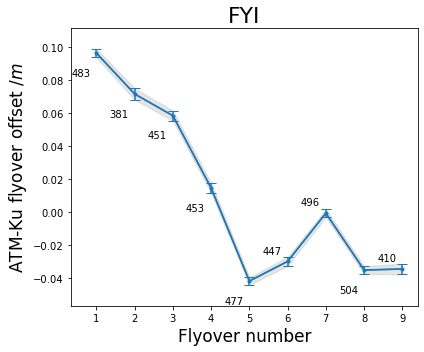

In [23]:
atm_ku_flyover_offset_means = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_lens = np.full(len(offset_list_2D),np.nan, dtype= 'double')
atm_ku_flyover_offset_stds = np.full(len(offset_list_2D),np.nan, dtype='double')
atm_ku_flyover_offset_stes = np.full(len(offset_list_2D),np.nan, dtype='double')
for i, file_offsets in enumerate(offset_list_2D):
#     if i==1:
#         pass
#         p(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_means[i] = np.nanmean(file_offsets)
    atm_ku_flyover_offset_stds[i] = np.nanstd(file_offsets, ddof=1)
    atm_ku_flyover_offset_stes[i] = np.nanstd(file_offsets, ddof=1)/np.sqrt(len(np.array(file_offsets)[~np.isnan(file_offsets)]))
    atm_ku_flyover_offset_lens[i] = len(np.array(file_offsets)[~np.isnan(file_offsets)])
#         print(np.nanmax(file_offsets))

print(atm_ku_flyover_offset_means)
print(atm_ku_flyover_offset_stds)
print(atm_ku_flyover_offset_lens)
fig = plt.figure(figsize=(6,5))
errorPlot(range(1,len(atm_ku_flyover_offset_means)+1),atm_ku_flyover_offset_means, atm_ku_flyover_offset_stes, point_labels=atm_ku_flyover_offset_lens)
plt.xticks(range(1,len(atm_ku_flyover_offset_means)+1))
plt.ylabel("ATM-Ku flyover offset $/m$",fontsize=17)
plt.xlabel("Flyover number",fontsize=17)
plt.title(icetype.upper(), fontsize=22)
plt.tight_layout()
# plt.savefig("../Thesis/graphics/ATMKuFlyoverOffsets"+str(icetype).upper()+".png", dpi=200)

#uncomment this line if you want a global offset instead of a file-by-file offset:
# atm_ku_flyover_offset_means[:] = np.nanmean(fflat(offset_list_2D))

In [24]:
angle_thresh=3
waveform_arr = np.array([],dtype='object')

for ku_file_counter, ku_file in enumerate(coincident_ku_files):

    x_ku,y_ku,alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, appropriate_indices = correctEastNorthKu(ku_file, coord_sys="ease")
    ku_subpath = "ku/"
    try:
        nc = netCDF4.Dataset(ku_file) #making an nc file in the format that Python can understand
    except FileNotFoundError:
        try:
            nc = netCDF4.Dataset(ku_subpath+ku_file)
        except FileNotFoundError:
            nc = netCDF4.Dataset(ku_path+ku_file)
    log_amplitude = nc['amplitude'][appropriate_indices] #a 2-D array of stacked waveforms, with the first index being waveform number 
                                    #and the second being the range bin number of a particular waveform. 
                                  #Contains log-amplitude waveform data
                                    #Shape = [number of waveforms x number of range bins in each waveform]
    fasttime_ku = nc['fasttime'][:]
    j=-1
    for footprint, footprint_data in footprintDataYielder(x_ku, y_ku, alt_ku, pitch_ku, roll_ku, aircraft_alt_ku, azi_angle, atm_laser.coords, overlapping_kdtree):
        j+=1
        #the altitudes of the ATM data within a particular ku footprint:
        atm_alts_within = [atm_laser.alt[datum] for datum in footprint_data]
        #the rolls of the ATM data within a particular ku footprint:
        atm_rolls_within = [atm_laser.roll[datum] for datum in footprint_data]
        atm_pitches_within = [atm_laser.pitch[datum] for datum in footprint_data]
        if len(atm_alts_within)>0 and \
        abs(roll_ku[j]*180/np.pi)<angle_thresh and \
        abs(pitch_ku[j]*180/np.pi)<angle_thresh and \
        all(abs(atm_roll*180/np.pi)<angle_thresh for atm_roll in atm_rolls_within) and \
        all(abs(atm_pitch*180/np.pi)<angle_thresh for atm_pitch in atm_pitches_within):
            unlog_amp = 10**(np.array(log_amplitude[j])/10)
            wavef = Waveform(unlog_amp, fasttime_ku, easting=x_ku[j],northing=y_ku[j],\
                             aircraft_alt=aircraft_alt_ku[j] + atm_ku_flyover_offset_means[ku_file_counter], footprint_polygon = footprint, \
                             footprint_atm_alts = atm_alts_within)

            waveform_arr = np.append(waveform_arr, wavef)2
                            

In [26]:
ku_airsnow_alts = np.array([],dtype='double')
atm_airsnow_alts = np.array([],dtype='double')
for waveform in waveform_arr:

    if (waveform.estimated_air_snow_alt!=np.nan and waveform.estimated_air_snow_alt!= None and str(waveform.estimated_air_snow_alt)!='nan') and np.any(waveform.footprint_atm_alts):
        ku_airsnow_alts = np.append(ku_airsnow_alts, waveform.estimated_air_snow_alt)
        atm_airsnow_alts = np.append(atm_airsnow_alts, np.nanmean(waveform.footprint_atm_alts))
        

5.978892564463101
0.0012052399227190857
4102
5.978892564463095
0.0008890564866805923


Text(0, 0.5, 'Altitude of Airsnow\nInterface wrt WGS84 $/m$')

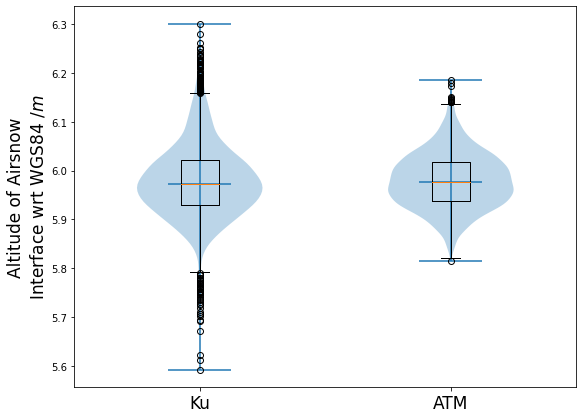

In [27]:
print(np.mean(ku_airsnow_alts))
print(np.std(ku_airsnow_alts,ddof=1)/np.sqrt(len(ku_airsnow_alts)))
print(len(atm_airsnow_alts))
print(np.mean(atm_airsnow_alts))
print(np.std(atm_airsnow_alts,ddof=1)/np.sqrt(len(atm_airsnow_alts)))
fig = plt.figure(figsize = (9,7))
plt.violinplot([ku_airsnow_alts, atm_airsnow_alts], showmedians = True)
plt.boxplot([ku_airsnow_alts, atm_airsnow_alts])
plt.xticks(ticks = np.arange(1,3,1), labels = ['Ku','ATM'], fontsize = 17)
plt.ylabel("Altitude of Airsnow\nInterface wrt WGS84 $/m$",fontsize=17)
# plt.savefig("../Thesis/graphics/"+str(icetype).upper()+"ATMAndKuAirSnowVoilinPlots.png",dpi=200)

0.059298555485155245
-0.001443486173318529 0.04008809717792822


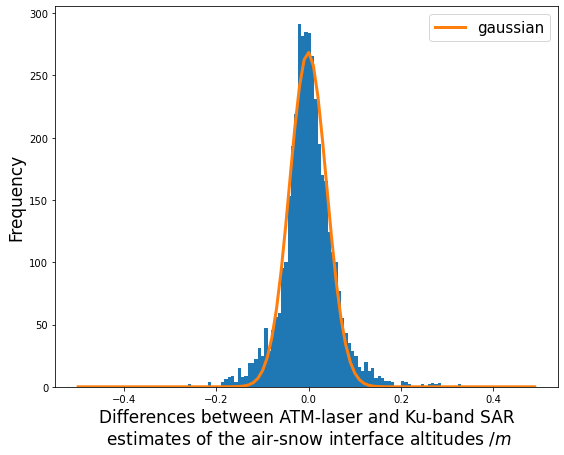

In [30]:
fig = plt.figure(figsize = (9,7))
atm_airsnow_alts_minus_ku_airsnow_alts = atm_airsnow_alts - ku_airsnow_alts
plt.hist(atm_airsnow_alts_minus_ku_airsnow_alts, bins =100);
plt.ylabel("Frequency",fontsize=17)
plt.xlabel("Differences between ATM-laser and Ku-band SAR\n estimates of the air-snow interface altitudes $/m$",fontsize=17)

print(np.std(atm_airsnow_alts - ku_airsnow_alts,ddof=1))
mean= np.mean(np.array(atm_airsnow_alts_minus_ku_airsnow_alts)[(np.percentile(atm_airsnow_alts_minus_ku_airsnow_alts,20)< np.array(atm_airsnow_alts_minus_ku_airsnow_alts)) & (np.percentile(atm_airsnow_alts_minus_ku_airsnow_alts,80)> np.array(atm_airsnow_alts_minus_ku_airsnow_alts))])
standard_deviation = np.std(np.array(atm_airsnow_alts_minus_ku_airsnow_alts)[(np.percentile(atm_airsnow_alts_minus_ku_airsnow_alts,4)< np.array(atm_airsnow_alts_minus_ku_airsnow_alts)) & (np.percentile(atm_airsnow_alts_minus_ku_airsnow_alts,96)> np.array(atm_airsnow_alts_minus_ku_airsnow_alts))],ddof=1)
print(mean, standard_deviation)
x_values = np.arange(-0.5, 0.5, 0.01)
y_values = stats.norm(mean, standard_deviation)

plt.plot(x_values, y_values.pdf(x_values)*27, label = 'gaussian', linewidth=3)
plt.legend(loc='best', prop = {'size':15})
# plt.savefig("../Thesis/graphics/"+str(icetype).upper()+"ATMMinusKuAirSnowHist.png",dpi=200)